In [26]:
!pip install -q stellargraph[demos]==1.2.1

In [27]:
!pip install -q openpyxl

In [28]:
# !pip install tensorflow-gpu

In [29]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [181]:
!ls

assignment-1-part-III-for-students-2.ipynb     GCN.ipynb
dummy.xlsx				       logs.log
file_for_network.csv			       node2vec.ipynb
foo3.pdf				       node2vec_link_prediction.ipynb
foo3.png				       pathway-tf-final.xlsx
foo.pdf					       pathway-tf.xlsx
foo.png					       tf_cascadid_colour_label_2.png
GCN-2.ipynb				       tf_cascadid_colour_label_3.png
GCN-3 networkx for tf-pathway.ipynb	       tf_cascadid_colour_label.png
GCN-4 stelllargraph.ipynb		       tfc_graph_analysis.csv
GCN-5 stelllargraph-Node2Vec-2.ipynb	       tfc_graph_colour.png
GCN-5 stelllargraph-Node2Vec.ipynb.html        tfs.edges
gcn-for-amlsim-dataset-x009th-iteration.ipynb  tmp


In [31]:
from stellargraph import StellarGraph
import json
import pandas as pd
import numpy as np
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.metrics import mean_absolute_error, mean_squared_error

import stellargraph as sg
from stellargraph.mapper import HinSAGELinkGenerator
from stellargraph.layer import HinSAGE, link_regression
from tensorflow.keras import Model, optimizers, losses, metrics

import multiprocessing
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [32]:
import pandas as pd

In [33]:
xl = pd.ExcelFile("pathway-tf-final.xlsx")
df = xl.parse("Sheet1", header=None)
# df.columns=["pathway","tfs"]
# df=df.head()
df1=df

In [34]:
df=df1

In [35]:
df.columns = df.iloc[0]
df = df[1:]
df.columns=["pathway", "weight", "tfs"]
cols=['tfs','pathway', 'weight']
df["weight"] = pd.to_numeric(df["weight"])
df = df[cols]
df

/scratch/slurm-269325/ipykernel_29371/1201075705.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["weight"] = pd.to_numeric(df["weight"])


,tfs,pathway,weight
1,"['STAT3', 'PRDM1']",acute myeloid leukemia,0.009716
2,"['STAT3', 'PRDM1']",adipocytokine signaling pathway,0.009716
3,"['STAT3', 'PRDM1']",pancreatic cancer,0.009716
4,"['STAT3', 'PRDM1']",jak stat signaling pathway,0.014745
5,"['STAT3', 'KLF5']",acute myeloid leukemia,0.009716
...,...,...,...
1048571,"['LEF1', 'MYC', 'SNAI1', 'NANOG', 'POU5F1', 'S...",cell cycle,0.235056
1048572,"['LEF1', 'MYC', 'SNAI1', 'NANOG', 'POU5F1', 'S...",focal adhesion,0.381879
1048573,"['LEF1', 'MYC', 'SNAI1', 'NANOG', 'POU5F1', 'S...",neuroactive ligand receptor interaction,0.437467
1048574,"['SMAD4', 'TBX18', 'SNAI2', 'STAT1', 'TBX21', ...",prostate cancer,0.000002


In [36]:
df.tail()

,tfs,pathway,weight
1048571,"['LEF1', 'MYC', 'SNAI1', 'NANOG', 'POU5F1', 'S...",cell cycle,0.235056
1048572,"['LEF1', 'MYC', 'SNAI1', 'NANOG', 'POU5F1', 'S...",focal adhesion,0.381879
1048573,"['LEF1', 'MYC', 'SNAI1', 'NANOG', 'POU5F1', 'S...",neuroactive ligand receptor interaction,0.437467
1048574,"['SMAD4', 'TBX18', 'SNAI2', 'STAT1', 'TBX21', ...",prostate cancer,0.000002
1048575,"['SMAD4', 'TBX18', 'SNAI2', 'STAT1', 'TBX21', ...",pancreatic cancer,0.000010


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 1 to 1048575
Data columns (total 3 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   tfs      1048575 non-null  object 
 1   pathway  1048575 non-null  object 
 2   weight   1048575 non-null  float64
dtypes: float64(1), object(2)
memory usage: 24.0+ MB


In [38]:
list_1=df["tfs"].value_counts()
print(list_1.__len__())
list_2=df["pathway"].value_counts()
print(list_2.__len__())

10000
49


In [39]:
df=df.drop_duplicates(subset=['tfs','pathway'],keep='first', inplace=False)

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 352577 entries, 1 to 1048559
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   tfs      352577 non-null  object 
 1   pathway  352577 non-null  object 
 2   weight   352577 non-null  float64
dtypes: float64(1), object(2)
memory usage: 10.8+ MB


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 352577 entries, 1 to 1048559
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   tfs      352577 non-null  object 
 1   pathway  352577 non-null  object 
 2   weight   352577 non-null  float64
dtypes: float64(1), object(2)
memory usage: 10.8+ MB


In [42]:
df=df.drop_duplicates( keep=False)
df.shape

(352577, 3)

In [43]:
list_1=df["pathway"].value_counts()
list_1.__len__()

49

In [44]:

df.columns=['source', 'target', 'weight']

In [45]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

def encode_df(dataframe):
    le = LabelEncoder()
    for column in ['source','target']:
        dataframe[column] = le.fit_transform(dataframe[column])
        dataframe[column] = dataframe[column].apply(str)
    return dataframe

#encode the dataframe
df=encode_df(df)
df = df[df.target != "cell cycle"]
df

,source,target,weight
1,8775,0,0.009716
2,8775,2,0.009716
3,8775,36,0.009716
4,8775,23,0.014745
5,8333,0,0.009716
...,...,...,...
1048494,2088,35,0.137568
1048553,2930,48,0.027106
1048557,2930,12,0.048064
1048558,2930,5,0.063702


In [46]:
list_1=df["target"].value_counts()
list_1.__len__()

49

In [47]:
df[["source","target"]].groupby( 'target' ). count()

,source
target,
0,10000
1,10000
10,10000
11,10000
12,6664
13,10000
14,667
15,10000
16,9997


In [48]:
df_copy=df1
df_copy.columns = df_copy.iloc[0]
df_copy = df_copy[1:]
df_copy.columns=["pathway", "weight", "tfs"]

df_tf=df_copy[["tfs"]]
df_encode=df[["source"]]
df_map=df_encode.join(df_tf)
df_map
# df_copy

,source,tfs
1,8775,"['STAT3', 'PRDM1']"
2,8775,"['STAT3', 'PRDM1']"
3,8775,"['STAT3', 'PRDM1']"
4,8775,"['STAT3', 'PRDM1']"
5,8333,"['STAT3', 'KLF5']"
...,...,...
1048494,2088,"['HMGA2', 'SOX2', 'NANOG', 'POU5F1', 'SALL4', ..."
1048553,2930,"['LEF1', 'MYC', 'SNAI1', 'NANOG', 'POU5F1', 'S..."
1048557,2930,"['LEF1', 'MYC', 'SNAI1', 'NANOG', 'POU5F1', 'S..."
1048558,2930,"['LEF1', 'MYC', 'SNAI1', 'NANOG', 'POU5F1', 'S..."


In [53]:
df_map.set_index("source", inplace = True)
df_map.head()
df_map.columns=["subject"]
df_map.index.name=None
df_map=df_map.drop_duplicates()
subjects=df_map.squeeze()
subjects

8775                                   ['STAT3', 'PRDM1']
8333                                    ['STAT3', 'KLF5']
7743                                   ['STAT3', 'CEBPD']
8828                                    ['STAT3', 'RORC']
8641                                   ['STAT3', 'NANOG']
                              ...                        
9963    ['ZHX1', 'EGR1', 'SNAI1', 'NANOG', 'POU5F1', '...
304     ['ASH1L', 'FOXP3', 'IRF8', 'SNAI1', 'NANOG', '...
9217    ['STAT3', 'ZEB1', 'AR', 'NANOG', 'POU5F1', 'SA...
501     ['ATF4', 'ATF3', 'STAT3', 'SALL4', 'NANOG', 'P...
8025    ['STAT3', 'FOXO3', 'TP53', 'NANOG', 'POU5F1', ...
Name: subject, Length: 10000, dtype: object

In [54]:
df_pathway=df_copy[["pathway"]]
df_encode=df[["target"]]
df_map_pathway=df_encode.join(df_pathway)
df_map_pathway

,target,pathway
1,0,acute myeloid leukemia
2,2,adipocytokine signaling pathway
3,36,pancreatic cancer
4,23,jak stat signaling pathway
5,0,acute myeloid leukemia
...,...,...
1048494,35,notch signaling pathway
1048553,48,vegf signaling pathway
1048557,12,circadian rhythm
1048558,5,axon guidance


In [55]:
df_tf=df_copy[["tfs","pathway"]]
df_tf=df_tf.drop_duplicates(subset='tfs', keep="first")
df_tf

,tfs,pathway
1,"['STAT3', 'PRDM1']",acute myeloid leukemia
5,"['STAT3', 'KLF5']",acute myeloid leukemia
9,"['STAT3', 'CEBPD']",acute myeloid leukemia
13,"['STAT3', 'RORC']",acute myeloid leukemia
17,"['STAT3', 'NANOG']",acute myeloid leukemia
...,...,...
470254,"['ZHX1', 'EGR1', 'SNAI1', 'NANOG', 'POU5F1', '...",colorectal cancer
474339,"['ASH1L', 'FOXP3', 'IRF8', 'SNAI1', 'NANOG', '...",prostate cancer
476278,"['STAT3', 'ZEB1', 'AR', 'NANOG', 'POU5F1', 'SA...",acute myeloid leukemia
479124,"['ATF4', 'ATF3', 'STAT3', 'SALL4', 'NANOG', 'P...",colorectal cancer


## Stellargraph

In [56]:
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 352577 entries, 1 to 1048559
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   source  352577 non-null  object 
 1   target  352577 non-null  object 
 2   weight  352577 non-null  float64
dtypes: float64(1), object(2)
memory usage: 18.8+ MB


In [57]:
# cols=['source', 'target']
cols = df.columns
square_edges = df[cols]
square_edges

,source,target,weight
1,8775,0,0.009716
2,8775,2,0.009716
3,8775,36,0.009716
4,8775,23,0.014745
5,8333,0,0.009716
...,...,...,...
1048494,2088,35,0.137568
1048553,2930,48,0.027106
1048557,2930,12,0.048064
1048558,2930,5,0.063702


In [58]:
square = StellarGraph(edges=square_edges)
print(square.info())

StellarGraph: Undirected multigraph
 Nodes: 10000, Edges: 352577

 Node types:
  default: [10000]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [352577]
        Weights: range=[1.13e-19, 0.437467], mean=0.0922638, std=0.0879348
        Features: none


In [59]:
square_named = StellarGraph(
    edges=square_edges, #node_type_default="tfs", edge_type_default="pathway"
)
print(square_named.info())

StellarGraph: Undirected multigraph
 Nodes: 10000, Edges: 352577

 Node types:
  default: [10000]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [352577]
        Weights: range=[1.13e-19, 0.437467], mean=0.0922638, std=0.0879348
        Features: none


In [60]:
# square_named

In [61]:
# square_edges_first_second = square_edges.rename(
#     columns={"source": "tfs", "target": "pathway"}
# )
# square_edges_first_second

In [62]:
# square_first_second = StellarGraph(
#     edges=square_edges_first_second, source_column="tfs", target_column="pathway",node_type_default="tfs", edge_type_default="pathway"
# )
# print(square_first_second.info())

In [63]:

import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, HinSAGE, link_classification

from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection

from stellargraph import globalvar
from stellargraph import datasets
from IPython.display import display, HTML
%matplotlib inline

In [64]:
G=square
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 10000, Edges: 352577

 Node types:
  default: [10000]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [352577]
        Weights: range=[1.13e-19, 0.437467], mean=0.0922638, std=0.0879348
        Features: none


In [65]:
# Define an edge splitter on the original graph G:
edge_splitter_test = EdgeSplitter(G)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G, and obtain the
# reduced graph G_test with the sampled links removed:
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global", keep_connected=True
)

** Sampled 35257 positive and 35257 negative edges. **


In [66]:
# Define an edge splitter on the reduced graph G_test:
edge_splitter_train = EdgeSplitter(G_test)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G_test, and obtain the
# reduced graph G_train with the sampled links removed:
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=0.1, method="global", keep_connected=True
)

** Sampled 31732 positive and 31732 negative edges. **


In [67]:
print(G_train.info())

StellarGraph: Undirected multigraph
 Nodes: 10000, Edges: 285588

 Node types:
  default: [10000]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [285588]
        Weights: range=[1.13e-19, 0.437467], mean=0.0916616, std=0.0878953
        Features: none


In [68]:
print(G_test.info())

StellarGraph: Undirected multigraph
 Nodes: 10000, Edges: 317320

 Node types:
  default: [10000]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [317320]
        Weights: range=[1.13e-19, 0.437467], mean=0.0919945, std=0.0879545
        Features: none


# NODE2VEC

In [69]:
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import pairwise_distances
from sklearn import preprocessing

import numpy as np

from stellargraph.data import BiasedRandomWalk
from stellargraph import StellarGraph

from gensim.models import Word2Vec

import warnings
import collections
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt

%matplotlib inline

In [70]:
walk_length = 100  # maximum length of a random walk to use throughout this notebook

In [71]:
G = StellarGraph(
    edges=square_edges, node_type_default="tfs", edge_type_default="pathway"
)
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 10000, Edges: 352577

 Node types:
  tfs: [10000]
    Features: none
    Edge types: tfs-pathway->tfs

 Edge types:
    tfs-pathway->tfs: [352577]
        Weights: range=[1.13e-19, 0.437467], mean=0.0922638, std=0.0879348
        Features: none


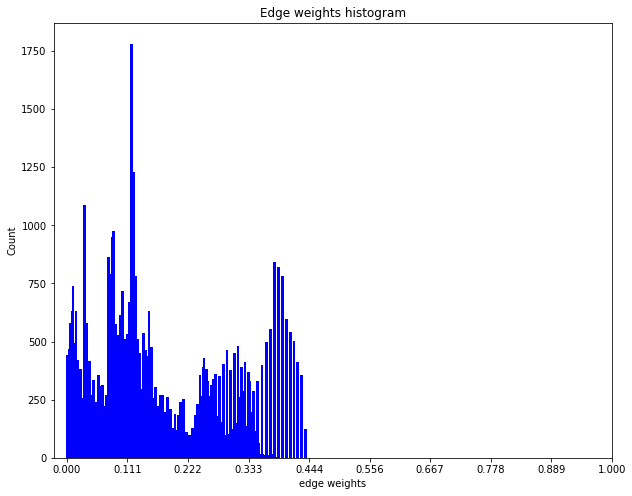

In [72]:
_, weights = G.edges(include_edge_weight=True)

wt, cnt = np.unique(weights, return_counts=True)

plt.figure(figsize=(10, 8))
plt.bar(wt, cnt, width=0.005, color="b")
plt.title("Edge weights histogram")
plt.ylabel("Count")
plt.xlabel("edge weights")
plt.xticks(np.linspace(0, 1, 10))

plt.show()

In [73]:
rw = BiasedRandomWalk(G)

In [74]:
weighted_walks = rw.run(
    nodes=G.nodes(),  # root nodes
    length=walk_length,  # maximum length of a random walk
    n=10,  # number of random walks per root node
    p=0.5,  # Defines (unormalised) probability, 1/p, of returning to source node
    q=2.0,  # Defines (unormalised) probability, 1/q, for moving away from source node
    weighted=True,  # for weighted random walks
    seed=42,  # random seed fixed for reproducibility
)
print("Number of random walks: {}".format(len(weighted_walks)))

Number of random walks: 100000


In [75]:
weighted_model = Word2Vec(
    weighted_walks, size=128, window=5, min_count=0, sg=1, workers=1, iter=1
)

In [76]:
node_ids = weighted_model.wv.index2word

In [77]:
print(node_ids.__len__())
print(node_ids[50])

10000
2668


In [78]:
# The embedding vectors can be retrieved from model.wv using the node ID as key.
# E.g., for node id '19231', the embedding vector is retrieved as
# emb = weighted_model.wv["focal adhesion"]
emb = weighted_model.wv["2668"]
emb.shape

(128,)

In [79]:
emb.shape

(128,)

In [83]:
print("check")

check


# Visualise Node Embeddings generated by weighted random walks

In [84]:
df
# df.shape

,source,target,weight
1,8775,0,0.009716
2,8775,2,0.009716
3,8775,36,0.009716
4,8775,23,0.014745
5,8333,0,0.009716
...,...,...,...
1048494,2088,35,0.137568
1048553,2930,48,0.027106
1048557,2930,12,0.048064
1048558,2930,5,0.063702


In [85]:
list_1=df["source"].unique()
print(list_1)
list_2=df["target"].unique()
print(list_2)
print(list_1.__len__())
print(list_2.__len__())
list_1=list_1.tolist()
# print(list_1)
list_2=list_2.tolist()
# print(list_2)
l_final=list_1+list_2
print(l_final.__len__())

['8775' '8333' '7743' ... '9217' '501' '8025']
['0' '2' '36' '23' '25' '30' '42' '3' '44' '22' '9' '15' '34' '7' '19'
 '29' '11' '4' '13' '43' '39' '10' '26' '6' '46' '17' '1' '48' '5' '31'
 '14' '12' '28' '24' '20' '16' '18' '38' '37' '35' '27' '41' '40' '45'
 '47' '33' '8' '32' '21']
10000
49
10049


In [86]:
# myList = l_final                                                                                                               
# mySeries = pd.Series(myList)  
# mySeries.index = l_final
# print(type(mySeries))
# subjects=mySeries
# subjects

df_map.head()

,subject
8775,"['STAT3', 'PRDM1']"
8333,"['STAT3', 'KLF5']"
7743,"['STAT3', 'CEBPD']"
8828,"['STAT3', 'RORC']"
8641,"['STAT3', 'NANOG']"


In [87]:
# Retrieve node embeddings and corresponding subjects
node_ids = weighted_model.wv.index2word  # list of node IDs
weighted_node_embeddings = (
    weighted_model.wv.vectors
)  # numpy.ndarray of size number of nodes times embeddings dimensionality
# the gensim ordering may not match the StellarGraph one, so rearrange
node_targets = subjects.loc[node_ids].astype("category")

In [88]:
# Apply t-SNE transformation on node embeddings
tsne = TSNE(n_components=2, random_state=42)
weighted_node_embeddings_2d = tsne.fit_transform(weighted_node_embeddings)

In [89]:
# c=node_targets.cat.codes
c=node_targets
print(type(c))
c

<class 'pandas.core.series.Series'>


32      ['AHR', 'ATF4', 'ATF3', 'STAT3', 'SALL4', 'NAN...
18      ['AHR', 'ATF4', 'ATF3', 'STAT3', 'SALL4', 'NAN...
20      ['AHR', 'ATF4', 'ATF3', 'STAT3', 'SALL4', 'NAN...
31      ['AHR', 'ATF4', 'ATF3', 'STAT3', 'SALL4', 'NAN...
5                ['AHR', 'ATF4', 'ATF3', 'STAT3', 'JUNB']
                              ...                        
8907    ['STAT3', 'SNAI1', 'NANOG', 'POU5F1', 'SALL4',...
9126    ['STAT3', 'TP53', 'NANOG', 'POU5F1', 'SALL4', ...
8196    ['STAT3', 'JUNB', 'JUN', 'NANOG', 'POU5F1', 'S...
8903    ['STAT3', 'SNAI1', 'NANOG', 'POU5F1', 'SALL4',...
7916    ['STAT3', 'FOS', 'SNAI1', 'NANOG', 'POU5F1', '...
Name: subject, Length: 10000, dtype: category
Categories (10000, object): ['['AHR', 'ATF4', 'ATF3', 'STAT3', 'BATF']', '['AHR', 'ATF4', 'ATF3', 'STAT3', 'CEBPD']', '['AHR', 'ATF4', 'ATF3', 'STAT3', 'HIF1A']', '['AHR', 'ATF4', 'ATF3', 'STAT3', 'HLX']', ..., '['ZNF467', 'PPARG', 'TP53', 'NANOG', 'POU5F1'..., '['ZNF467', 'PPARG', 'TP53', 'NANOG', 'POU5F1'..., '['

In [98]:
c1=df_tf.pathway
c1=c1.astype('category')
print(type(c1))
c1

<class 'pandas.core.series.Series'>


1         acute myeloid leukemia
5         acute myeloid leukemia
9         acute myeloid leukemia
13        acute myeloid leukemia
17        acute myeloid leukemia
                   ...          
470254         colorectal cancer
474339           prostate cancer
476278    acute myeloid leukemia
479124         colorectal cancer
548546    acute myeloid leukemia
Name: pathway, Length: 10000, dtype: category
Categories (23, object): ['acute myeloid leukemia', 'adherens junction', 'adipocytokine signaling pathway', 'b cell receptor signaling pathway', ..., 'prion disease', 'prostate cancer', 'renal cell carcinoma', 'thyroid cancer']

In [99]:
c1=c1.cat.codes
c1

1          0
5          0
9          0
13         0
17         0
          ..
470254     7
474339    20
476278     0
479124     7
548546     0
Length: 10000, dtype: int8

In [100]:
weighted_node_embeddings_2d[:, 0].shape

(10000,)

In [101]:
weighted_node_embeddings_2d[:, 1].shape

(10000,)

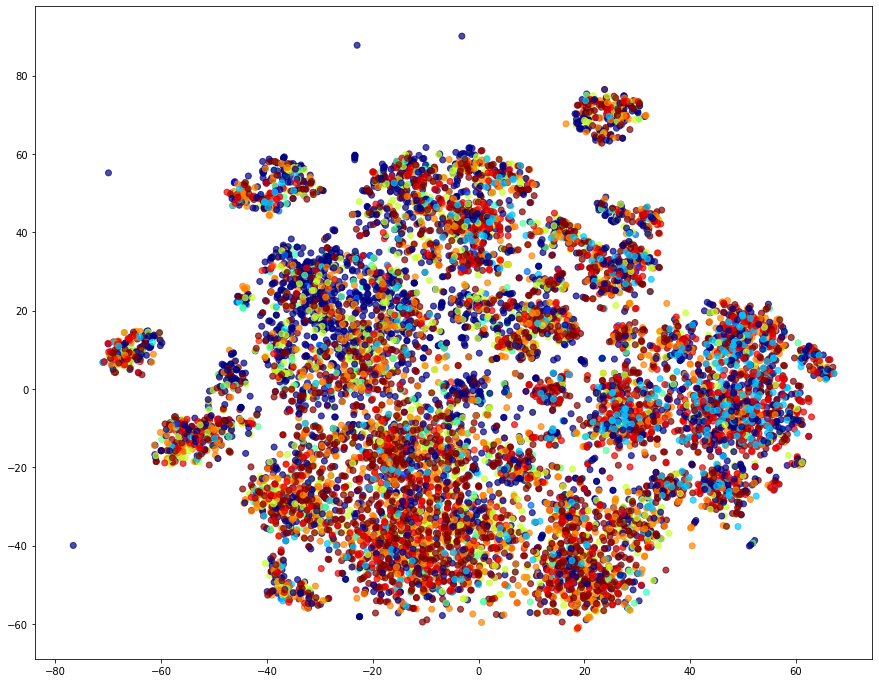

In [130]:
# draw the points
alpha = 0.7

plt.figure(figsize=(15, 12))
plt.scatter(
    weighted_node_embeddings_2d[:, 0],
    weighted_node_embeddings_2d[:, 1],
    c=c1,
    cmap="jet",
    alpha=0.7,
)
plt.show()

In [103]:
print("check")

check


# Downstrean task

In [115]:
y1=df_tf.pathway
y1=y1.values
print(type(y1))

<class 'numpy.ndarray'>


In [116]:
# X will hold the 128-dimensional input features
X = weighted_node_embeddings
# y holds the corresponding target values
# y = np.array(node_targets)
y=y1

In [120]:
y1.__len__()

10000

In [119]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.75, test_size=None, random_state=42
)
print(
    "Array shapes:\n X_train = {}\n y_train = {}\n X_test = {}\n y_test = {}".format(
        X_train.shape, y_train.shape, X_test.shape, y_test.shape
    )
)

Array shapes:
 X_train = (7500, 128)
 y_train = (7500,)
 X_test = (2500, 128)
 y_test = (2500,)


In [121]:
y_train

array(['thyroid cancer', 'thyroid cancer', 'thyroid cancer', ...,
       'acute myeloid leukemia', 'acute myeloid leukemia',
       'thyroid cancer'], dtype=object)

In [126]:
clf = LogisticRegressionCV(
    Cs=10,
    cv=None,
    tol=0.001,
    max_iter=1000,
    scoring="accuracy",
    verbose=False,
    multi_class="ovr",
    random_state=5434,
)
clf.fit(X_train, y_train)

/ihome/yanshanwang/sos86/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


LogisticRegressionCV(max_iter=1000, multi_class='ovr', random_state=5434,
                     scoring='accuracy', tol=0.001, verbose=False)

In [127]:
# clf = LogisticRegression(
# #     Cs=10,
# #     cv=None,
# #     tol=0.001,
# #     max_iter=1000,
# #     scoring="accuracy",
# #     verbose=False,
# #     multi_class="ovr",
#     random_state=5434,
# )
# clf.fit(X_train, y_train)

In [128]:
y_pred = clf.predict(X_test)

In [129]:
accuracy_score(y_test, y_pred)

0.3488

In [184]:
print("check")

check


# PyCaret

In [216]:
# compare machine learning algorithms on the sonar classification dataset
from pandas import read_csv
from pycaret.classification import setup
from pycaret.classification import compare_models
# # define the location of the dataset
# url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/sonar.csv'
# # load the dataset
# df = read_csv(url, header=None)
# # set column names as the column number
# n_cols = df.shape[1]
# df.columns = [str(i) for i in range(n_cols)]
# # setup the dataset
# grid = setup(data=df, target=df.columns[-1], html=False, silent=True, verbose=False)
# # evaluate models and compare models
# best = compare_models()
# # report the best model
# print(best)

In [217]:
np.random.seed(123)
X_train_df=pd.DataFrame(X_train) 
X_train_df.info()
X_test_df=pd.DataFrame(X_test) 
X_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Columns: 128 entries, 0 to 127
dtypes: float32(128)
memory usage: 3.7 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Columns: 128 entries, 0 to 127
dtypes: float32(128)
memory usage: 1.2 MB


In [218]:
y_train_df=pd.DataFrame(y_train) 
y_train_df.columns=["target"]
y_train_df.info()
y_test_df=pd.DataFrame(y_test) 
y_test_df.columns=["target"]
y_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  7500 non-null   object
dtypes: object(1)
memory usage: 58.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  2500 non-null   object
dtypes: object(1)
memory usage: 19.7+ KB


In [219]:
train = pd.concat([X_train_df,y_train_df],axis=1)
# print(train.describe)
test = pd.concat([X_test_df,y_test_df],axis=1)
# print(test.describe)

In [220]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,target
0,-0.013936,0.026896,-0.116564,0.065105,-0.009753,-0.113997,0.272549,0.148707,0.010748,-0.101183,...,-0.076226,0.005654,0.002546,-0.048540,-0.001689,0.274308,-0.042825,-0.065916,0.033987,thyroid cancer
1,-0.008513,-0.072242,-0.111167,0.026449,0.001723,-0.006937,0.251574,0.100213,-0.021419,-0.066303,...,-0.106144,-0.021165,0.037795,-0.071122,-0.019259,0.302119,-0.043031,-0.007531,0.076357,thyroid cancer
2,0.022905,-0.111318,-0.094842,0.048794,-0.052920,-0.125831,0.231894,0.092743,0.016437,-0.101206,...,-0.130920,0.129040,-0.024759,-0.128246,-0.040198,0.230728,-0.065401,-0.023281,0.053529,thyroid cancer
3,0.006732,-0.100821,-0.211997,0.000258,-0.025710,-0.116796,0.249173,0.082899,0.068549,-0.062747,...,-0.036320,0.036948,0.112607,-0.139685,-0.082198,0.137511,-0.018240,-0.040188,0.006720,prostate cancer
4,0.014603,-0.095795,-0.221790,0.026771,-0.078987,-0.047138,0.283173,-0.019120,0.034257,-0.003297,...,-0.075212,0.011559,-0.052963,-0.242474,-0.004419,0.253619,-0.084713,-0.002425,0.036498,acute myeloid leukemia


In [221]:
# reg = setup(data = train,target = "target", numeric_imputation = 'mean',normalize = True
#             ,pca=True, pca_method='linear',pca_components=10,
#             html=False, silent=True, verbose=False,session_id = 3650)

# set column names as the column number
df=train
n_cols = df.shape[1]
print(n_cols)
df.columns = [str(i) for i in range(n_cols)]


129


In [222]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,128
0,-0.013936,0.026896,-0.116564,0.065105,-0.009753,-0.113997,0.272549,0.148707,0.010748,-0.101183,...,-0.076226,0.005654,0.002546,-0.048540,-0.001689,0.274308,-0.042825,-0.065916,0.033987,thyroid cancer
1,-0.008513,-0.072242,-0.111167,0.026449,0.001723,-0.006937,0.251574,0.100213,-0.021419,-0.066303,...,-0.106144,-0.021165,0.037795,-0.071122,-0.019259,0.302119,-0.043031,-0.007531,0.076357,thyroid cancer
2,0.022905,-0.111318,-0.094842,0.048794,-0.052920,-0.125831,0.231894,0.092743,0.016437,-0.101206,...,-0.130920,0.129040,-0.024759,-0.128246,-0.040198,0.230728,-0.065401,-0.023281,0.053529,thyroid cancer
3,0.006732,-0.100821,-0.211997,0.000258,-0.025710,-0.116796,0.249173,0.082899,0.068549,-0.062747,...,-0.036320,0.036948,0.112607,-0.139685,-0.082198,0.137511,-0.018240,-0.040188,0.006720,prostate cancer
4,0.014603,-0.095795,-0.221790,0.026771,-0.078987,-0.047138,0.283173,-0.019120,0.034257,-0.003297,...,-0.075212,0.011559,-0.052963,-0.242474,-0.004419,0.253619,-0.084713,-0.002425,0.036498,acute myeloid leukemia


In [223]:
# setup the dataset
grid = setup(data=df, target=df.columns[-1], normalize = True,
             pca=True, pca_method='linear',pca_components=3,
             html=False, silent=True, verbose=False,session_id = 3650)


INFO:logs:PyCaret Supervised Module
INFO:logs:ML Usecase: classification
INFO:logs:version 2.3.6
INFO:logs:Initializing setup()
INFO:logs:setup(target=128, ml_usecase=classification, available_plots={'parameter': 'Hyperparameters', 'auc': 'AUC', 'confusion_matrix': 'Confusion Matrix', 'threshold': 'Threshold', 'pr': 'Precision Recall', 'error': 'Prediction Error', 'class_report': 'Class Report', 'rfe': 'Feature Selection', 'learning': 'Learning Curve', 'manifold': 'Manifold Learning', 'calibration': 'Calibration Curve', 'vc': 'Validation Curve', 'dimension': 'Dimensions', 'feature': 'Feature Importance', 'feature_all': 'Feature Importance (All)', 'boundary': 'Decision Boundary', 'lift': 'Lift Chart', 'gain': 'Gain Chart', 'tree': 'Decision Tree', 'ks': 'KS Statistic Plot'}, train_size=0.7, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=constant, categorical_iterative_imputer=lightgbm, ordinal_feat

In [224]:
# evaluate models and compare models
best = compare_models(fold=2,cross_validation=True,n_select=3)
# report the best model


INFO:logs:Initializing compare_models()
INFO:logs:compare_models(include=None, fold=2, round=4, cross_validation=True, sort=Accuracy, n_select=3, budget_time=None, turbo=True, errors=ignore, fit_kwargs=None, groups=None, probability_threshold=None, verbose=True, display=None, exclude=None)
INFO:logs:Checking exceptions
INFO:logs:Preparing display monitor
INFO:logs:Preparing display monitor
INFO:logs:Initializing Logistic Regression
INFO:logs:Total runtime is 3.170967102050781e-05 minutes
INFO:logs:SubProcess create_model() called ==================================
INFO:logs:Initializing create_model()
INFO:logs:create_model(estimator=lr, fold=StratifiedKFold(n_splits=2, random_state=None, shuffle=False), round=4, cross_validation=True, predict=True, fit_kwargs={}, groups=None, refit=False, verbose=False, system=False, metrics=None, add_to_model_list=True, probability_threshold=None, display=<pycaret.internal.Display.Display object at 0x7fb5e9b53460>, kwargs={})
INFO:logs:Checking excep

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.3332,0.0,0.0642,0.1991,0.2351,0.0916,0.1073,1.53


INFO:logs:Initializing K Neighbors Classifier
INFO:logs:Total runtime is 0.06323032379150391 minutes
INFO:logs:SubProcess create_model() called ==================================
INFO:logs:Initializing create_model()
INFO:logs:create_model(estimator=knn, fold=StratifiedKFold(n_splits=2, random_state=None, shuffle=False), round=4, cross_validation=True, predict=True, fit_kwargs={}, groups=None, refit=False, verbose=False, system=False, metrics=None, add_to_model_list=True, probability_threshold=None, display=<pycaret.internal.Display.Display object at 0x7fb5e9b53460>, kwargs={})
INFO:logs:Checking exceptions
INFO:logs:Importing libraries
INFO:logs:Copying training dataset
INFO:logs:Defining folds
INFO:logs:Declaring metric variables
INFO:logs:Importing untrained model
INFO:logs:K Neighbors Classifier Imported succesfully
INFO:logs:Starting cross validation
INFO:logs:Cross validating with StratifiedKFold(n_splits=2, random_state=None, shuffle=False), n_jobs=-1
INFO:logs:Calculating mean 

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.3332,0.0,0.0642,0.1991,0.2351,0.0916,0.1073,1.53
knn,K Neighbors Classifier,0.2692,0.0,0.0628,0.2335,0.2440,0.0640,0.0653,0.14


INFO:logs:Initializing Naive Bayes
INFO:logs:Total runtime is 0.08018262386322023 minutes
INFO:logs:SubProcess create_model() called ==================================
INFO:logs:Initializing create_model()
INFO:logs:create_model(estimator=nb, fold=StratifiedKFold(n_splits=2, random_state=None, shuffle=False), round=4, cross_validation=True, predict=True, fit_kwargs={}, groups=None, refit=False, verbose=False, system=False, metrics=None, add_to_model_list=True, probability_threshold=None, display=<pycaret.internal.Display.Display object at 0x7fb5e9b53460>, kwargs={})
INFO:logs:Checking exceptions
INFO:logs:Importing libraries
INFO:logs:Copying training dataset
INFO:logs:Defining folds
INFO:logs:Declaring metric variables
INFO:logs:Importing untrained model
INFO:logs:Naive Bayes Imported succesfully
INFO:logs:Starting cross validation
INFO:logs:Cross validating with StratifiedKFold(n_splits=2, random_state=None, shuffle=False), n_jobs=-1
INFO:logs:Calculating mean and std
INFO:logs:Creat

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.3332,0.0,0.0642,0.1991,0.2351,0.0916,0.1073,1.53
nb,Naive Bayes,0.3311,0.0,0.0639,0.1990,0.2355,0.0905,0.1069,0.03
knn,K Neighbors Classifier,0.2692,0.0,0.0628,0.2335,0.2440,0.0640,0.0653,0.14


INFO:logs:Initializing Decision Tree Classifier
INFO:logs:Total runtime is 0.09342850049336753 minutes
INFO:logs:SubProcess create_model() called ==================================
INFO:logs:Initializing create_model()
INFO:logs:create_model(estimator=dt, fold=StratifiedKFold(n_splits=2, random_state=None, shuffle=False), round=4, cross_validation=True, predict=True, fit_kwargs={}, groups=None, refit=False, verbose=False, system=False, metrics=None, add_to_model_list=True, probability_threshold=None, display=<pycaret.internal.Display.Display object at 0x7fb5e9b53460>, kwargs={})
INFO:logs:Checking exceptions
INFO:logs:Importing libraries
INFO:logs:Copying training dataset
INFO:logs:Defining folds
INFO:logs:Declaring metric variables
INFO:logs:Importing untrained model
INFO:logs:Decision Tree Classifier Imported succesfully
INFO:logs:Starting cross validation
INFO:logs:Cross validating with StratifiedKFold(n_splits=2, random_state=None, shuffle=False), n_jobs=-1
INFO:logs:Calculating me

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.3332,0.0,0.0642,0.1991,0.2351,0.0916,0.1073,1.530
nb,Naive Bayes,0.3311,0.0,0.0639,0.1990,0.2355,0.0905,0.1069,0.030
knn,K Neighbors Classifier,0.2692,0.0,0.0628,0.2335,0.2440,0.0640,0.0653,0.140
dt,Decision Tree Classifier,0.2307,0.0,0.0577,0.2319,0.2312,0.0498,0.0499,0.045


INFO:logs:Initializing SVM - Linear Kernel
INFO:logs:Total runtime is 0.10718540350596112 minutes
INFO:logs:SubProcess create_model() called ==================================
INFO:logs:Initializing create_model()
INFO:logs:create_model(estimator=svm, fold=StratifiedKFold(n_splits=2, random_state=None, shuffle=False), round=4, cross_validation=True, predict=True, fit_kwargs={}, groups=None, refit=False, verbose=False, system=False, metrics=None, add_to_model_list=True, probability_threshold=None, display=<pycaret.internal.Display.Display object at 0x7fb5e9b53460>, kwargs={})
INFO:logs:Checking exceptions
INFO:logs:Importing libraries
INFO:logs:Copying training dataset
INFO:logs:Defining folds
INFO:logs:Declaring metric variables
INFO:logs:Importing untrained model
INFO:logs:SVM - Linear Kernel Imported succesfully
INFO:logs:Starting cross validation
INFO:logs:Cross validating with StratifiedKFold(n_splits=2, random_state=None, shuffle=False), n_jobs=-1
INFO:logs:Calculating mean and st

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.3332,0.0,0.0642,0.1991,0.2351,0.0916,0.1073,1.530
nb,Naive Bayes,0.3311,0.0,0.0639,0.1990,0.2355,0.0905,0.1069,0.030
svm,SVM - Linear Kernel,0.2766,0.0,0.0630,0.2530,0.2279,0.0581,0.0614,0.170
knn,K Neighbors Classifier,0.2692,0.0,0.0628,0.2335,0.2440,0.0640,0.0653,0.140
dt,Decision Tree Classifier,0.2307,0.0,0.0577,0.2319,0.2312,0.0498,0.0499,0.045


INFO:logs:Initializing Ridge Classifier
INFO:logs:Total runtime is 0.12504130999247234 minutes
INFO:logs:SubProcess create_model() called ==================================
INFO:logs:Initializing create_model()
INFO:logs:create_model(estimator=ridge, fold=StratifiedKFold(n_splits=2, random_state=None, shuffle=False), round=4, cross_validation=True, predict=True, fit_kwargs={}, groups=None, refit=False, verbose=False, system=False, metrics=None, add_to_model_list=True, probability_threshold=None, display=<pycaret.internal.Display.Display object at 0x7fb5e9b53460>, kwargs={})
INFO:logs:Checking exceptions
INFO:logs:Importing libraries
INFO:logs:Copying training dataset
INFO:logs:Defining folds
INFO:logs:Declaring metric variables
INFO:logs:Importing untrained model
INFO:logs:Ridge Classifier Imported succesfully
INFO:logs:Starting cross validation
INFO:logs:Cross validating with StratifiedKFold(n_splits=2, random_state=None, shuffle=False), n_jobs=-1
INFO:logs:Calculating mean and std
IN

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.3338,0.0,0.0641,0.1820,0.2344,0.0913,0.1061,0.025
lr,Logistic Regression,0.3332,0.0,0.0642,0.1991,0.2351,0.0916,0.1073,1.530
nb,Naive Bayes,0.3311,0.0,0.0639,0.1990,0.2355,0.0905,0.1069,0.030
svm,SVM - Linear Kernel,0.2766,0.0,0.0630,0.2530,0.2279,0.0581,0.0614,0.170
knn,K Neighbors Classifier,0.2692,0.0,0.0628,0.2335,0.2440,0.0640,0.0653,0.140
dt,Decision Tree Classifier,0.2307,0.0,0.0577,0.2319,0.2312,0.0498,0.0499,0.045


INFO:logs:Initializing Random Forest Classifier
INFO:logs:Total runtime is 0.13804527521133425 minutes
INFO:logs:SubProcess create_model() called ==================================
INFO:logs:Initializing create_model()
INFO:logs:create_model(estimator=rf, fold=StratifiedKFold(n_splits=2, random_state=None, shuffle=False), round=4, cross_validation=True, predict=True, fit_kwargs={}, groups=None, refit=False, verbose=False, system=False, metrics=None, add_to_model_list=True, probability_threshold=None, display=<pycaret.internal.Display.Display object at 0x7fb5e9b53460>, kwargs={})
INFO:logs:Checking exceptions
INFO:logs:Importing libraries
INFO:logs:Copying training dataset
INFO:logs:Defining folds
INFO:logs:Declaring metric variables
INFO:logs:Importing untrained model
INFO:logs:Random Forest Classifier Imported succesfully
INFO:logs:Starting cross validation
INFO:logs:Cross validating with StratifiedKFold(n_splits=2, random_state=None, shuffle=False), n_jobs=-1
INFO:logs:Calculating me

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.3338,0.0,0.0641,0.1820,0.2344,0.0913,0.1061,0.025
lr,Logistic Regression,0.3332,0.0,0.0642,0.1991,0.2351,0.0916,0.1073,1.530
nb,Naive Bayes,0.3311,0.0,0.0639,0.1990,0.2355,0.0905,0.1069,0.030
rf,Random Forest Classifier,0.2877,0.0,0.0657,0.2484,0.2599,0.0790,0.0804,0.860
svm,SVM - Linear Kernel,0.2766,0.0,0.0630,0.2530,0.2279,0.0581,0.0614,0.170
knn,K Neighbors Classifier,0.2692,0.0,0.0628,0.2335,0.2440,0.0640,0.0653,0.140
dt,Decision Tree Classifier,0.2307,0.0,0.0577,0.2319,0.2312,0.0498,0.0499,0.045


INFO:logs:Initializing Quadratic Discriminant Analysis
INFO:logs:Total runtime is 0.1790090839068095 minutes
INFO:logs:SubProcess create_model() called ==================================
INFO:logs:Initializing create_model()
INFO:logs:create_model(estimator=qda, fold=StratifiedKFold(n_splits=2, random_state=None, shuffle=False), round=4, cross_validation=True, predict=True, fit_kwargs={}, groups=None, refit=False, verbose=False, system=False, metrics=None, add_to_model_list=True, probability_threshold=None, display=<pycaret.internal.Display.Display object at 0x7fb5e9b53460>, kwargs={})
INFO:logs:Checking exceptions
INFO:logs:Importing libraries
INFO:logs:Copying training dataset
INFO:logs:Defining folds
INFO:logs:Declaring metric variables
INFO:logs:Importing untrained model
INFO:logs:Quadratic Discriminant Analysis Imported succesfully
INFO:logs:Starting cross validation
INFO:logs:Cross validating with StratifiedKFold(n_splits=2, random_state=None, shuffle=False), n_jobs=-1
INFO:logs:

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.3338,0.0,0.0641,0.1820,0.2344,0.0913,0.1061,0.025
lr,Logistic Regression,0.3332,0.0,0.0642,0.1991,0.2351,0.0916,0.1073,1.530
nb,Naive Bayes,0.3311,0.0,0.0639,0.1990,0.2355,0.0905,0.1069,0.030
ada,Ada Boost Classifier,0.3273,0.0,0.0666,0.1756,0.2281,0.0835,0.0963,0.600
rf,Random Forest Classifier,0.2877,0.0,0.0657,0.2484,0.2599,0.0790,0.0804,0.860
svm,SVM - Linear Kernel,0.2766,0.0,0.0630,0.2530,0.2279,0.0581,0.0614,0.170
knn,K Neighbors Classifier,0.2692,0.0,0.0628,0.2335,0.2440,0.0640,0.0653,0.140
dt,Decision Tree Classifier,0.2307,0.0,0.0577,0.2319,0.2312,0.0498,0.0499,0.045


INFO:logs:Initializing Gradient Boosting Classifier
INFO:logs:Total runtime is 0.2356874982515971 minutes
INFO:logs:SubProcess create_model() called ==================================
INFO:logs:Initializing create_model()
INFO:logs:create_model(estimator=gbc, fold=StratifiedKFold(n_splits=2, random_state=None, shuffle=False), round=4, cross_validation=True, predict=True, fit_kwargs={}, groups=None, refit=False, verbose=False, system=False, metrics=None, add_to_model_list=True, probability_threshold=None, display=<pycaret.internal.Display.Display object at 0x7fb5e9b53460>, kwargs={})
INFO:logs:Checking exceptions
INFO:logs:Importing libraries
INFO:logs:Copying training dataset
INFO:logs:Defining folds
INFO:logs:Declaring metric variables
INFO:logs:Importing untrained model
INFO:logs:Gradient Boosting Classifier Imported succesfully
INFO:logs:Starting cross validation
INFO:logs:Cross validating with StratifiedKFold(n_splits=2, random_state=None, shuffle=False), n_jobs=-1
INFO:logs:Calcul

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.3338,0.0,0.0641,0.1820,0.2344,0.0913,0.1061,0.025
lr,Logistic Regression,0.3332,0.0,0.0642,0.1991,0.2351,0.0916,0.1073,1.530
nb,Naive Bayes,0.3311,0.0,0.0639,0.1990,0.2355,0.0905,0.1069,0.030
ada,Ada Boost Classifier,0.3273,0.0,0.0666,0.1756,0.2281,0.0835,0.0963,0.600
gbc,Gradient Boosting Classifier,0.3111,0.0,0.0619,0.2556,0.2595,0.0956,0.1009,11.090
rf,Random Forest Classifier,0.2877,0.0,0.0657,0.2484,0.2599,0.0790,0.0804,0.860
svm,SVM - Linear Kernel,0.2766,0.0,0.0630,0.2530,0.2279,0.0581,0.0614,0.170
knn,K Neighbors Classifier,0.2692,0.0,0.0628,0.2335,0.2440,0.0640,0.0653,0.140
dt,Decision Tree Classifier,0.2307,0.0,0.0577,0.2319,0.2312,0.0498,0.0499,0.045


INFO:logs:Initializing Linear Discriminant Analysis
INFO:logs:Total runtime is 0.6186443010965983 minutes
INFO:logs:SubProcess create_model() called ==================================
INFO:logs:Initializing create_model()
INFO:logs:create_model(estimator=lda, fold=StratifiedKFold(n_splits=2, random_state=None, shuffle=False), round=4, cross_validation=True, predict=True, fit_kwargs={}, groups=None, refit=False, verbose=False, system=False, metrics=None, add_to_model_list=True, probability_threshold=None, display=<pycaret.internal.Display.Display object at 0x7fb5e9b53460>, kwargs={})
INFO:logs:Checking exceptions
INFO:logs:Importing libraries
INFO:logs:Copying training dataset
INFO:logs:Defining folds
INFO:logs:Declaring metric variables
INFO:logs:Importing untrained model
INFO:logs:Linear Discriminant Analysis Imported succesfully
INFO:logs:Starting cross validation
INFO:logs:Cross validating with StratifiedKFold(n_splits=2, random_state=None, shuffle=False), n_jobs=-1
INFO:logs:Calcul

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.3338,0.0,0.0641,0.1820,0.2344,0.0913,0.1061,0.025
lda,Linear Discriminant Analysis,0.3336,0.0,0.0628,0.1999,0.2355,0.0925,0.1086,0.025
lr,Logistic Regression,0.3332,0.0,0.0642,0.1991,0.2351,0.0916,0.1073,1.530
nb,Naive Bayes,0.3311,0.0,0.0639,0.1990,0.2355,0.0905,0.1069,0.030
ada,Ada Boost Classifier,0.3273,0.0,0.0666,0.1756,0.2281,0.0835,0.0963,0.600
gbc,Gradient Boosting Classifier,0.3111,0.0,0.0619,0.2556,0.2595,0.0956,0.1009,11.090
rf,Random Forest Classifier,0.2877,0.0,0.0657,0.2484,0.2599,0.0790,0.0804,0.860
svm,SVM - Linear Kernel,0.2766,0.0,0.0630,0.2530,0.2279,0.0581,0.0614,0.170
knn,K Neighbors Classifier,0.2692,0.0,0.0628,0.2335,0.2440,0.0640,0.0653,0.140
dt,Decision Tree Classifier,0.2307,0.0,0.0577,0.2319,0.2312,0.0498,0.0499,0.045


INFO:logs:Initializing Extra Trees Classifier
INFO:logs:Total runtime is 0.6318173766136169 minutes
INFO:logs:SubProcess create_model() called ==================================
INFO:logs:Initializing create_model()
INFO:logs:create_model(estimator=et, fold=StratifiedKFold(n_splits=2, random_state=None, shuffle=False), round=4, cross_validation=True, predict=True, fit_kwargs={}, groups=None, refit=False, verbose=False, system=False, metrics=None, add_to_model_list=True, probability_threshold=None, display=<pycaret.internal.Display.Display object at 0x7fb5e9b53460>, kwargs={})
INFO:logs:Checking exceptions
INFO:logs:Importing libraries
INFO:logs:Copying training dataset
INFO:logs:Defining folds
INFO:logs:Declaring metric variables
INFO:logs:Importing untrained model
INFO:logs:Extra Trees Classifier Imported succesfully
INFO:logs:Starting cross validation
INFO:logs:Cross validating with StratifiedKFold(n_splits=2, random_state=None, shuffle=False), n_jobs=-1
INFO:logs:Calculating mean an

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.3338,0.0,0.0641,0.1820,0.2344,0.0913,0.1061,0.025
lda,Linear Discriminant Analysis,0.3336,0.0,0.0628,0.1999,0.2355,0.0925,0.1086,0.025
lr,Logistic Regression,0.3332,0.0,0.0642,0.1991,0.2351,0.0916,0.1073,1.530
nb,Naive Bayes,0.3311,0.0,0.0639,0.1990,0.2355,0.0905,0.1069,0.030
ada,Ada Boost Classifier,0.3273,0.0,0.0666,0.1756,0.2281,0.0835,0.0963,0.600
gbc,Gradient Boosting Classifier,0.3111,0.0,0.0619,0.2556,0.2595,0.0956,0.1009,11.090
rf,Random Forest Classifier,0.2877,0.0,0.0657,0.2484,0.2599,0.0790,0.0804,0.860
et,Extra Trees Classifier,0.2835,0.0,0.0616,0.2452,0.2580,0.0776,0.0788,0.655
svm,SVM - Linear Kernel,0.2766,0.0,0.0630,0.2530,0.2279,0.0581,0.0614,0.170
knn,K Neighbors Classifier,0.2692,0.0,0.0628,0.2335,0.2440,0.0640,0.0653,0.140


INFO:logs:Initializing Light Gradient Boosting Machine
INFO:logs:Total runtime is 0.6658848047256469 minutes
INFO:logs:SubProcess create_model() called ==================================
INFO:logs:Initializing create_model()
INFO:logs:create_model(estimator=lightgbm, fold=StratifiedKFold(n_splits=2, random_state=None, shuffle=False), round=4, cross_validation=True, predict=True, fit_kwargs={}, groups=None, refit=False, verbose=False, system=False, metrics=None, add_to_model_list=True, probability_threshold=None, display=<pycaret.internal.Display.Display object at 0x7fb5e9b53460>, kwargs={})
INFO:logs:Checking exceptions
INFO:logs:Importing libraries
INFO:logs:Copying training dataset
INFO:logs:Defining folds
INFO:logs:Declaring metric variables
INFO:logs:Importing untrained model
INFO:logs:Light Gradient Boosting Machine Imported succesfully
INFO:logs:Starting cross validation
INFO:logs:Cross validating with StratifiedKFold(n_splits=2, random_state=None, shuffle=False), n_jobs=-1
INFO:

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.3338,0.0,0.0641,0.1820,0.2344,0.0913,0.1061,0.025
lda,Linear Discriminant Analysis,0.3336,0.0,0.0628,0.1999,0.2355,0.0925,0.1086,0.025
lr,Logistic Regression,0.3332,0.0,0.0642,0.1991,0.2351,0.0916,0.1073,1.530
nb,Naive Bayes,0.3311,0.0,0.0639,0.1990,0.2355,0.0905,0.1069,0.030
ada,Ada Boost Classifier,0.3273,0.0,0.0666,0.1756,0.2281,0.0835,0.0963,0.600
gbc,Gradient Boosting Classifier,0.3111,0.0,0.0619,0.2556,0.2595,0.0956,0.1009,11.090
rf,Random Forest Classifier,0.2877,0.0,0.0657,0.2484,0.2599,0.0790,0.0804,0.860
lightgbm,Light Gradient Boosting Machine,0.2873,0.0,0.0679,0.2495,0.2635,0.0850,0.0860,2.835
et,Extra Trees Classifier,0.2835,0.0,0.0616,0.2452,0.2580,0.0776,0.0788,0.655
svm,SVM - Linear Kernel,0.2766,0.0,0.0630,0.2530,0.2279,0.0581,0.0614,0.170


INFO:logs:Initializing Dummy Classifier
INFO:logs:Total runtime is 0.7728342413902283 minutes
INFO:logs:SubProcess create_model() called ==================================
INFO:logs:Initializing create_model()
INFO:logs:create_model(estimator=dummy, fold=StratifiedKFold(n_splits=2, random_state=None, shuffle=False), round=4, cross_validation=True, predict=True, fit_kwargs={}, groups=None, refit=False, verbose=False, system=False, metrics=None, add_to_model_list=True, probability_threshold=None, display=<pycaret.internal.Display.Display object at 0x7fb5e9b53460>, kwargs={})
INFO:logs:Checking exceptions
INFO:logs:Importing libraries
INFO:logs:Copying training dataset
INFO:logs:Defining folds
INFO:logs:Declaring metric variables
INFO:logs:Importing untrained model
INFO:logs:Dummy Classifier Imported succesfully
INFO:logs:Starting cross validation
INFO:logs:Cross validating with StratifiedKFold(n_splits=2, random_state=None, shuffle=False), n_jobs=-1
INFO:logs:Calculating mean and std
INF

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.3338,0.0,0.0641,0.1820,0.2344,0.0913,0.1061,0.025
lda,Linear Discriminant Analysis,0.3336,0.0,0.0628,0.1999,0.2355,0.0925,0.1086,0.025
lr,Logistic Regression,0.3332,0.0,0.0642,0.1991,0.2351,0.0916,0.1073,1.530
nb,Naive Bayes,0.3311,0.0,0.0639,0.1990,0.2355,0.0905,0.1069,0.030
ada,Ada Boost Classifier,0.3273,0.0,0.0666,0.1756,0.2281,0.0835,0.0963,0.600
gbc,Gradient Boosting Classifier,0.3111,0.0,0.0619,0.2556,0.2595,0.0956,0.1009,11.090
rf,Random Forest Classifier,0.2877,0.0,0.0657,0.2484,0.2599,0.0790,0.0804,0.860
lightgbm,Light Gradient Boosting Machine,0.2873,0.0,0.0679,0.2495,0.2635,0.0850,0.0860,2.835
et,Extra Trees Classifier,0.2835,0.0,0.0616,0.2452,0.2580,0.0776,0.0788,0.655
svm,SVM - Linear Kernel,0.2766,0.0,0.0630,0.2530,0.2279,0.0581,0.0614,0.170


INFO:logs:Initializing create_model()
INFO:logs:create_model(estimator=RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=3650,
                solver='auto', tol=0.001), fold=StratifiedKFold(n_splits=2, random_state=None, shuffle=False), round=4, cross_validation=False, predict=False, fit_kwargs={}, groups=None, refit=True, verbose=False, system=False, metrics=None, add_to_model_list=True, probability_threshold=None, display=None, kwargs={})
INFO:logs:Checking exceptions
INFO:logs:Importing libraries
INFO:logs:Copying training dataset
INFO:logs:Defining folds
INFO:logs:Declaring metric variables
INFO:logs:Importing untrained model
INFO:logs:Declaring custom model
INFO:logs:Ridge Classifier Imported succesfully
INFO:logs:Cross validation set to False
INFO:logs:Fitting Model
INFO:logs:RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normal

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.3338,0.0,0.0641,0.1820,0.2344,0.0913,0.1061,0.025
lda,Linear Discriminant Analysis,0.3336,0.0,0.0628,0.1999,0.2355,0.0925,0.1086,0.025
lr,Logistic Regression,0.3332,0.0,0.0642,0.1991,0.2351,0.0916,0.1073,1.530
nb,Naive Bayes,0.3311,0.0,0.0639,0.1990,0.2355,0.0905,0.1069,0.030
ada,Ada Boost Classifier,0.3273,0.0,0.0666,0.1756,0.2281,0.0835,0.0963,0.600
gbc,Gradient Boosting Classifier,0.3111,0.0,0.0619,0.2556,0.2595,0.0956,0.1009,11.090
rf,Random Forest Classifier,0.2877,0.0,0.0657,0.2484,0.2599,0.0790,0.0804,0.860
lightgbm,Light Gradient Boosting Machine,0.2873,0.0,0.0679,0.2495,0.2635,0.0850,0.0860,2.835
et,Extra Trees Classifier,0.2835,0.0,0.0616,0.2452,0.2580,0.0776,0.0788,0.655
svm,SVM - Linear Kernel,0.2766,0.0,0.0630,0.2530,0.2279,0.0581,0.0614,0.170


INFO:logs:create_model_container: 15
INFO:logs:master_model_container: 15
INFO:logs:display_container: 2
INFO:logs:[RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=3650,
                solver='auto', tol=0.001), LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001), LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=3650, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)]
INFO:logs:compare_models() succesfully completed......................................


In [225]:
print(best)

[RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=3650,
                solver='auto', tol=0.001), LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001), LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=3650, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)]


In [226]:
# best_model = compare_models(fold=2, n_select=10)
# print(best_model)

In [227]:
### TUNING MODELS

In [230]:
# grid = setup(data=df, target=df.columns[-1], html=False, silent=True, verbose=False)

In [ ]:
# from sklearn.ensemble import ExtraTreesClassifier
exp_name = setup(data=df, target=df.columns[-1])
lr = create_model('lr')

INFO:logs:PyCaret Supervised Module
INFO:logs:ML Usecase: classification
INFO:logs:version 2.3.6
INFO:logs:Initializing setup()
INFO:logs:setup(target=128, ml_usecase=classification, available_plots={'parameter': 'Hyperparameters', 'auc': 'AUC', 'confusion_matrix': 'Confusion Matrix', 'threshold': 'Threshold', 'pr': 'Precision Recall', 'error': 'Prediction Error', 'class_report': 'Class Report', 'rfe': 'Feature Selection', 'learning': 'Learning Curve', 'manifold': 'Manifold Learning', 'calibration': 'Calibration Curve', 'vc': 'Validation Curve', 'dimension': 'Dimensions', 'feature': 'Feature Importance', 'feature_all': 'Feature Importance (All)', 'boundary': 'Decision Boundary', 'lift': 'Lift Chart', 'gain': 'Gain Chart', 'tree': 'Decision Tree', 'ks': 'KS Statistic Plot'}, train_size=0.7, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=constant, categorical_iterative_imputer=lightgbm, ordinal_feat

IntProgress(value=0, description='Processing: ', max=3)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,21:32:57
Status,. . . . . . . . . . . . . . . . . .,Preprocessing Data


INFO:logs:Importing libraries
INFO:logs:Copying data for preprocessing
INFO:logs:Declaring preprocessing parameters
INFO:logs:Creating preprocessing pipeline
INFO:logs:Preprocessing pipeline created successfully
ERROR:logs:(Process Exit): setup has been interupted with user command 'quit'. setup must rerun.
INFO:logs:Creating global containers
INFO:logs:Internal pipeline: Pipeline(memory=None, steps=[('empty_step', 'passthrough')], verbose=False)


Text(value="Following data types have been inferred automatically, if they are correct press enter to continue…

,Data Type
0,Numeric
1,Numeric
2,Numeric
3,Numeric
4,Numeric
...,...
124,Numeric
125,Numeric
126,Numeric
127,Numeric


In [ ]:
tuned_lr = tune_model(lr)

In [ ]:
######################

## ..............

# Comparison to weighted and unweighted biased random walks

## ..............

In [102]:
walks = rw.run(
    nodes=G.nodes(),  # root nodes
    length=walk_length,  # maximum length of a random walk
    n=10,  # number of random walks per root node
    p=0.5,  # Defines (unormalised) probability, 1/p, of returning to source node
    q=2.0,  # Defines (unormalised) probability, 1/q, for moving away from source node
    weighted=False,  # since we are interested in unweighted walks
    seed=42,  # for reproducibility
)
print("Number of random walks: {}".format(len(walks)))

Number of random walks: 100490


In [103]:
model = Word2Vec(walks, size=128, window=5, min_count=0, sg=1, workers=1, iter=1)

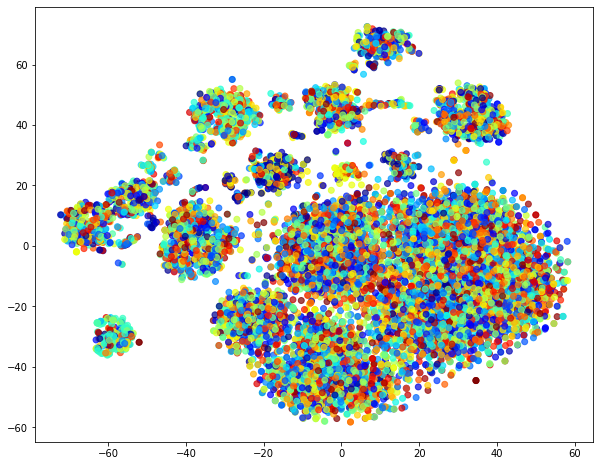

In [104]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index2word  # list of node IDs
node_embeddings = (
    model.wv.vectors
)  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = subjects.loc[node_ids].astype("category")

# Apply t-SNE transformation on node embeddings
tsne = TSNE(n_components=2, random_state=42)
node_embeddings_2d = tsne.fit_transform(node_embeddings)

# draw the points
alpha = 0.7

plt.figure(figsize=(10, 8))
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    c=node_targets.cat.codes,
    cmap="jet",
    alpha=0.7,
)
plt.show()

In [105]:
# X will hold the 128-dimensional input features
X = node_embeddings

# y holds the corresponding target values
y = np.array(node_targets)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.75, test_size=None, random_state=42
)
print(
    "Array shapes:\n X_train = {}\n y_train = {}\n X_test = {}\n y_test = {}".format(
        X_train.shape, y_train.shape, X_test.shape, y_test.shape
    )
)

Array shapes:
 X_train = (7536, 128)
 y_train = (7536,)
 X_test = (2513, 128)
 y_test = (2513,)


In [106]:
clf = LogisticRegression(
#     Cs=10,
#     cv=None,
#     tol=0.001,
#     max_iter=1000,
#     scoring="accuracy",
#     verbose=False,
#     multi_class="ovr",
    random_state=5434,
)
clf.fit(X_train, y_train)

LogisticRegression(random_state=5434)

In [107]:
y_pred = clf.predict(X_test)

In [108]:
accuracy_score(y_test, y_pred)

0.0

In [ ]:
print("check")

## ..............

# Testing whether weights = 1 gives identical result to unweighted random walks

## ..............

In [109]:
cols=['source', 'target']
# cols=df.columns
square_edges = df[cols]
square_edges

,source,target
1,"['STAT3', 'PRDM1']",acute myeloid leukemia
2,"['STAT3', 'PRDM1']",adipocytokine signaling pathway
3,"['STAT3', 'PRDM1']",pancreatic cancer
4,"['STAT3', 'PRDM1']",jak stat signaling pathway
5,"['STAT3', 'KLF5']",acute myeloid leukemia
...,...,...
1048494,"['HMGA2', 'SOX2', 'NANOG', 'POU5F1', 'SALL4', ...",notch signaling pathway
1048553,"['LEF1', 'MYC', 'SNAI1', 'NANOG', 'POU5F1', 'S...",vegf signaling pathway
1048557,"['LEF1', 'MYC', 'SNAI1', 'NANOG', 'POU5F1', 'S...",circadian rhythm
1048558,"['LEF1', 'MYC', 'SNAI1', 'NANOG', 'POU5F1', 'S...",axon guidance


In [110]:
walk_length = 100  # maximum length of a random walk to use throughout this notebook

In [113]:
unweighted_G = StellarGraph(
    edges=square_edges, node_type_default="tfs", edge_type_default="pathway"
)
print(unweighted_G.info())

StellarGraph: Undirected multigraph
 Nodes: 10049, Edges: 352577

 Node types:
  tfs: [10049]
    Features: none
    Edge types: tfs-pathway->tfs

 Edge types:
    tfs-pathway->tfs: [352577]
        Weights: all 1 (default)
        Features: none


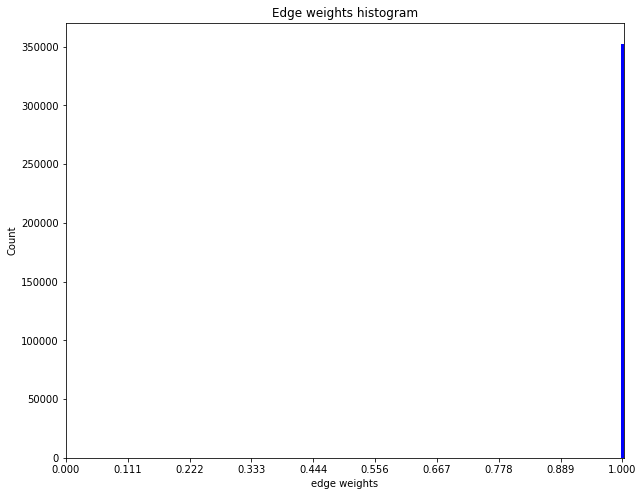

In [114]:
_, weights = unweighted_G.edges(include_edge_weight=True)

wt, cnt = np.unique(weights, return_counts=True)

plt.figure(figsize=(10, 8))
plt.bar(wt, cnt, width=0.005, color="b")
plt.title("Edge weights histogram")
plt.ylabel("Count")
plt.xlabel("edge weights")
plt.xticks(np.linspace(0, 1, 10))

plt.show()

In [115]:
rw = BiasedRandomWalk(unweighted_G)

In [116]:
weighted_walks = rw.run(
    nodes=unweighted_G.nodes(),  # root nodes
    length=walk_length,  # maximum length of a random walk
    n=10,  # number of random walks per root node
    p=0.5,  # Defines (unormalised) probability, 1/p, of returning to source node
    q=2.0,  # Defines (unormalised) probability, 1/q, for moving away from source node
    weighted=True,  # indicates the walks are weighted
    seed=42,  # seed fixed for reproducibility
)
print("Number of random walks: {}".format(len(weighted_walks)))

Number of random walks: 100490


In [117]:
assert walks == weighted_walks

In [ ]:
weighted_model = Word2Vec(
    weighted_walks, size=128, window=5, min_count=0, sg=1, workers=1, iter=1
)

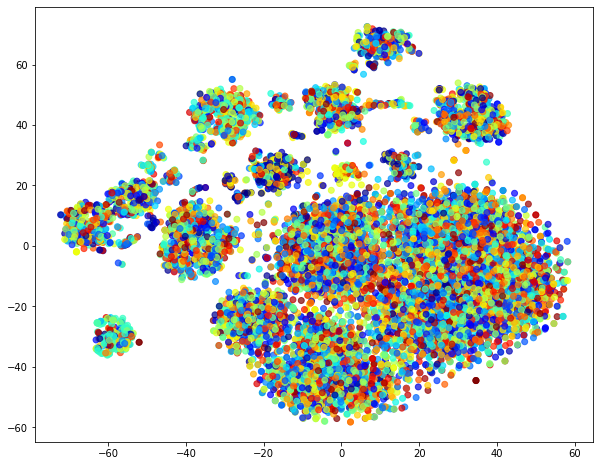

In [119]:
# Retrieve node embeddings and corresponding subjects
node_ids = weighted_model.wv.index2word  # list of node IDs
weighted_node_embeddings = (
    weighted_model.wv.vectors
)  # numpy.ndarray of size number of nodes times embeddings dimensionality

# Apply t-SNE transformation on node embeddings
tsne = TSNE(n_components=2, random_state=42)
weighted_node_embeddings_2d = tsne.fit_transform(weighted_node_embeddings)

# draw the points
alpha = 0.7

plt.figure(figsize=(10, 8))
plt.scatter(
    weighted_node_embeddings_2d[:, 0],
    weighted_node_embeddings_2d[:, 1],
    c=node_targets.cat.codes,
    cmap="jet",
    alpha=0.7,
)
plt.show()

In [120]:
# X will hold the 128-dimensional input features
X = weighted_node_embeddings

# y holds the corresponding target values
y = np.array(node_targets)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.75, test_size=None, random_state=42
)
print(
    "Array shapes:\n X_train = {}\n y_train = {}\n X_test = {}\n y_test = {}".format(
        X_train.shape, y_train.shape, X_test.shape, y_test.shape
    )
)

Array shapes:
 X_train = (7536, 128)
 y_train = (7536,)
 X_test = (2513, 128)
 y_test = (2513,)


In [125]:
clf = LogisticRegression(
#     Cs=10,
#     cv=10,
#     tol=0.01,
#     max_iter=1000,
#     scoring="accuracy",
#     verbose=False,
#     multi_class="ovr",
#     random_state=5434,
)
clf.fit(X_train, y_train)

LogisticRegression()

In [126]:
y_pred = clf.predict(X_test)


In [127]:
accuracy_score(y_test, y_pred)


0.0

In [ ]:
print("check")